In [1]:
%load_ext autoreload
%autoreload 2

import pickle
import copy
import numpy as np
from scipy.signal import find_peaks
import scipy.fftpack
from matplotlib import pyplot as plt
import seaborn as sns

from src.network import Layer
from src.ou_process import ouprocess_gaussian
from src.experiment import Experiment

sns.set()

In [11]:
NUM_NEURONS = 200
tau_V = 10
R = 1 # MOhm
EL = -70.0
V_th = -40.0
dt = 0.1 # msec
t_stop = 20.0e3

RESULTS_DIR = "./results"

In [3]:
# Slow Signal: INPUT
input_slow, _ = ouprocess_gaussian(50.0, dt, t_stop, 1)
i_inj = 16.0 + 6.0*input_slow

In [4]:
layer = Layer(NUM_NEURONS)
layer.train(i_inj=i_inj, exp_output=i_inj, dt=dt, t_stop=t_stop)
out, V, F_binary, F_synaptic = layer.output(i_inj, dt, t_stop)

C:\Users\Sayan Faraz\Documents\Projects\ReliableInfoTransfer\neural-learning\src\network.py:84: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  self.W, residuals, rank, s = np.linalg.lstsq(A, exp_output)


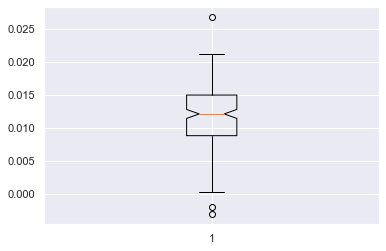

In [5]:
plt.boxplot(layer.W, notch=True, sym="o")
plt.show()

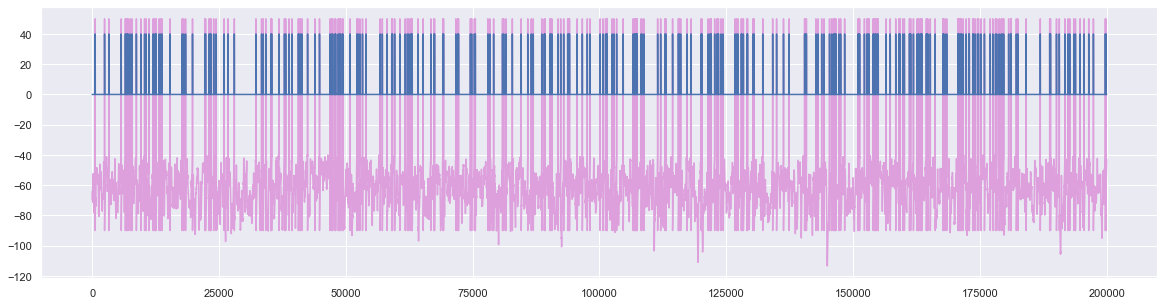

In [6]:
trial = 10
t_i = 0
t_f = -1
plt.figure(figsize=(20,5))
plt.plot(V[t_i:t_f,trial], color='plum')
plt.plot(F_binary[t_i:t_f,trial] * 40.0)
plt.show()

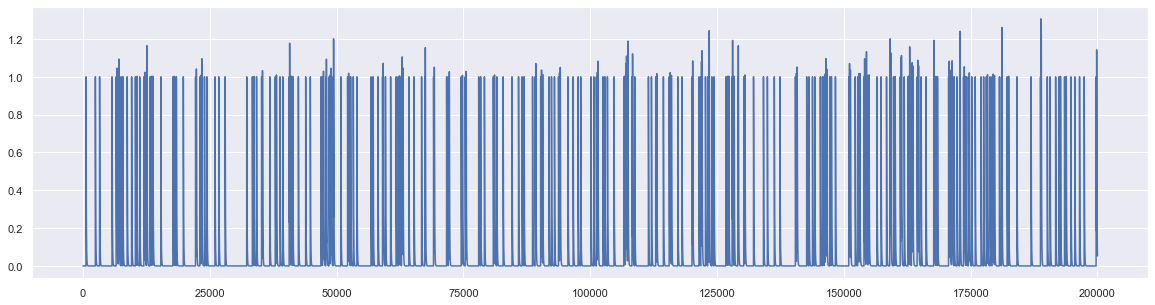

In [7]:
plt.figure(figsize=(20,5))
plt.plot(F_synaptic[:,10])
plt.show()

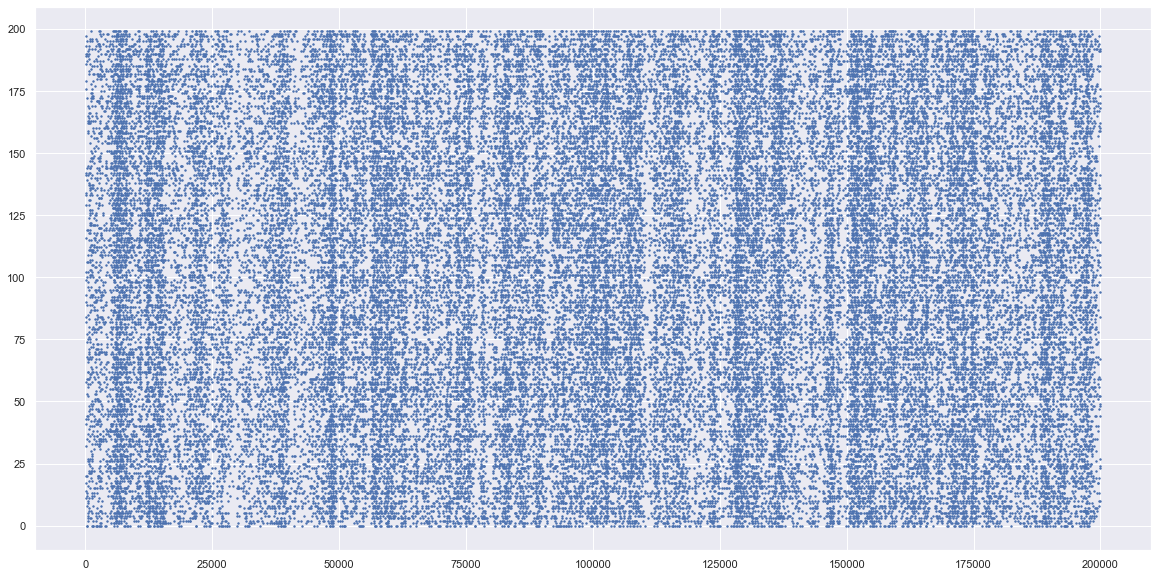

In [8]:
spike_inds, spike_trial = np.where(F_binary > 0)
plt.figure(figsize=(20,10))
plt.scatter(spike_inds, spike_trial, s=2)
plt.show()

In [24]:
a = np.where(F_binary[:,10] > 0)[0]
a.shape

(283,)

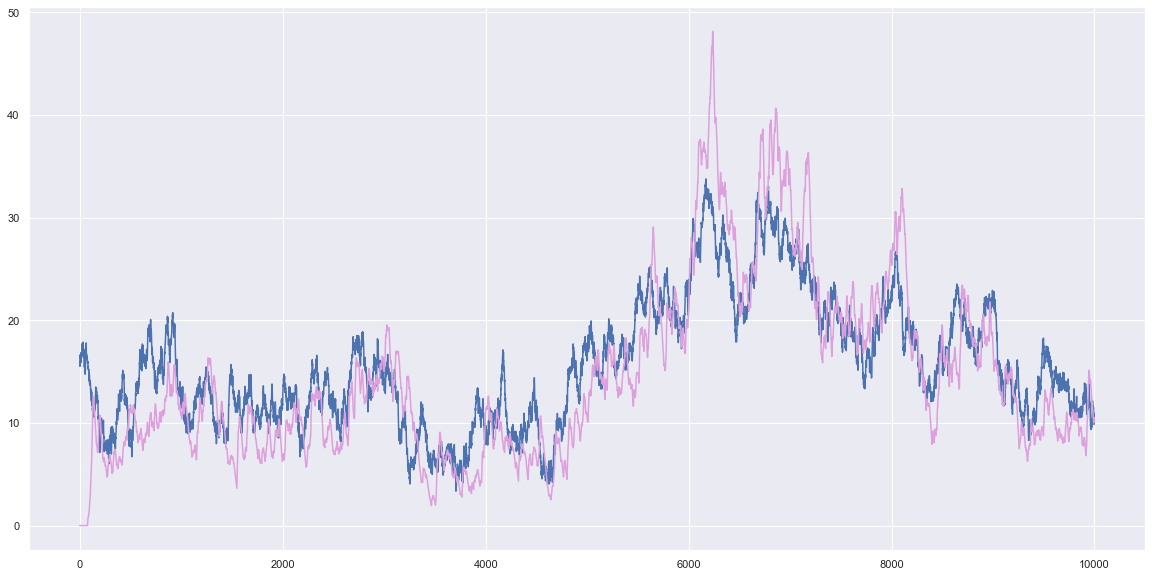

In [9]:
plt.figure(figsize=(20,10))
plt.plot(i_inj[:10000])
plt.plot(out[:10000], 'plum')
plt.show()

In [10]:
np.linalg.norm(out-i_inj)

1751.396782964039

### PoC 1a
For the SAME INPUT, can we shuffle / regenerate internal noise?

In [ ]:
LOAD_POC_1A = False
load_poc_1a_file = "poc1a__neurons=200__trials=100__input=tau_50_same"

if LOAD_EXP_1:
    experiment = Experiment.load(RESULTS_DIR, load_poc_1a_file)
else:
    NUM_TRIALS = 100

    num_t = np.arange(0.0, t_stop, dt).shape[0]
    inputs = np.empty((num_t, NUM_TRIALS))

    for i in range(NUM_TRIALS):
        inputs[:,i] = layer.train_input.flatten()

    experiment = Experiment(inputs, layer, NUM_TRIALS, dt, t_stop)
    spikes = experiment.run()
    experiment.save(RESULTS_DIR, load_poc_1a_file)

In [13]:
l2_norms = np.empty((experiment.num_trials))

for i in range(experiment.num_trials):
    l2_norms[i] = np.linalg.norm(experiment.outputs[:, i]-experiment.inputs[:, i])

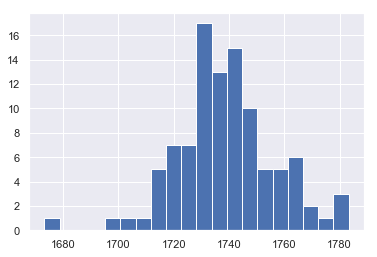

In [14]:
plt.hist(l2_norms, bins=20)
plt.show()

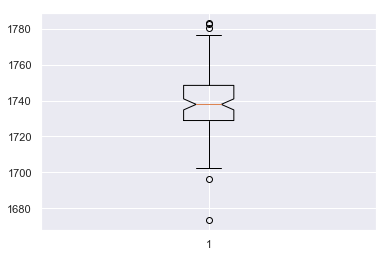

In [15]:
plt.boxplot(l2_norms, notch=True, sym="o")
plt.show()

### EXPERIMENT: How does amount of training data affect the weights?

In [20]:
import time

start_time = time.time()
loop_time = start_time

t_stop_var = 20.0e3

weights_v_training_t = []
training_ts = np.arange(1.0e3, 61.0e3, 10.0e3)

for t_stop_var in training_ts:
    # Slow Signal: INPUT
    input_slow, _ = ouprocess_gaussian(50.0, dt, t_stop_var, 1)
    i_inj = 16.0 + 6.0*input_slow
    layer_var = Layer(NUM_NEURONS)
    layer_var.train(i_inj=i_inj, exp_output=i_inj, dt=dt, t_stop=t_stop_var)
    
    weights_v_training_t += [layer_var.W]
    
    print("Training data length: ", t_stop_var)
    print("Iter time: ", time.time() - loop_time)
    print("Total time: ", time.time() - start_time)
    print("\n")
    loop_time = time.time()

Training data length:  1000.0
Iter time:  1.1870129108428955
Total time:  1.1870129108428955


Training data length:  11000.0
Iter time:  10.75909686088562
Total time:  11.946109771728516


Training data length:  21000.0
Iter time:  20.906447887420654
Total time:  32.85255765914917


Training data length:  31000.0
Iter time:  31.28421926498413
Total time:  64.1367769241333


Training data length:  41000.0
Iter time:  42.29997277259827
Total time:  106.43674969673157


Training data length:  51000.0
Iter time:  78.60202360153198
Total time:  185.21377182006836




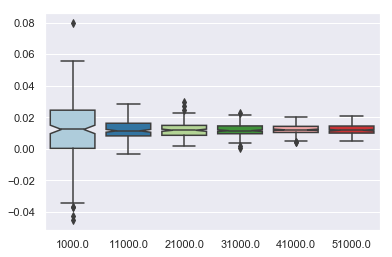

In [30]:
sns.boxplot(x=training_ts, y=weights_v_training_t, notch=True, sym="o", palette="Paired")
plt.show()

### PoC 1b
SAME INPUT: shuffle weights, how does this affect reconstruction?

In [13]:
LOAD_POC_1B = False
load_poc1b_file = "poc1b__neurons=200__trials=100__input=tau_50_same"

In [18]:
if LOAD_POC_1B:
    experiment = Experiment.load(RESULTS_DIR, load_poc_1B_file)
else:
    NUM_TRIALS = 100

    num_t = np.arange(0.0, t_stop, dt).shape[0]
    inputs = np.empty((num_t, NUM_TRIALS))

    for i in range(NUM_TRIALS):
        inputs[:,i] = layer.train_input.flatten()

    layer_shuffle = copy.deepcopy(layer)

    mean_weight = np.mean(layer_shuffle.W)
    std_weight = np.std(layer_shuffle.W)

    experiment = Experiment(inputs, layer_shuffle, NUM_TRIALS, dt, t_stop)

    for trial in range(NUM_TRIALS):
        experiment.layer.W = np.random.normal(mean_weight, std_weight, experiment.layer.W.shape)
        experiment.one_trial(trial)
    experiment.save(RESULTS_DIR, load_poc1b_file)

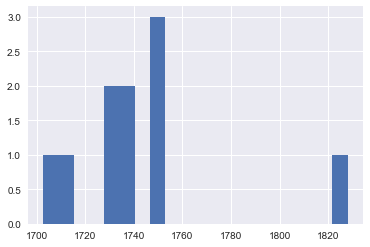

In [139]:
l2_norms = np.empty((experiment.num_trials))

for i in range(experiment.num_trials):
    l2_norms[i] = np.linalg.norm(experiment.outputs[:, i]-experiment.inputs[:, i])

plt.hist(l2_norms, bins=20)
plt.show()

### PoC 2a
DIFFERENT INPUTS: shuffle internal noise, how does this affect reconstruction?

In [10]:
LOAD_POC_2A = True
load_poc_2a_file = "poc2a__neurons=200__trials=100__input=tau_50_regenerated"

In [11]:
if LOAD_POC_2A:
    experiment = Experiment.load(RESULTS_DIR, load_poc_2a_file)
else:
    NUM_TRIALS = 100

    num_t = np.arange(0.0, t_stop, dt).shape[0]
    inputs = np.empty((num_t, NUM_TRIALS))

    for i in range(NUM_TRIALS):
        input_slow, _ = ouprocess_gaussian(50.0, dt, t_stop, 1)
        i_inj = 16.0 + 6.0*input_slow
        inputs[:,i] = i_inj.flatten()

    experiment = Experiment(inputs, layer, NUM_TRIALS, dt, t_stop)
    spikes = experiment.run()
    experiment.save(RESULTS_DIR, load_poc_2a_file)

In [12]:
l2_norms = np.empty((experiment.num_trials))

for i in range(experiment.num_trials):
    l2_norms[i] = np.linalg.norm(experiment.outputs[:, i]-experiment.inputs[:, i])

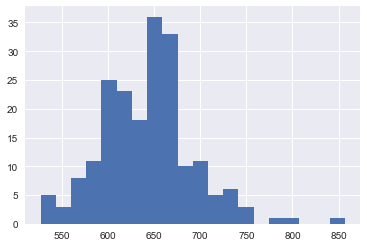

In [21]:
plt.hist(l2_norms, bins=20)
plt.show()

In [ ]:
plt.boxplot(l2_norms, notch=True, sym="o")
plt.show()

### PoC 2b
DIFFERENT INPUTS: shuffle weights, how does this affect reconstruction?

In [ ]:
LOAD_POC_2B = True
load_poc_2b_file = "poc2b__neurons=200__trials=100__input=tau_50_regenerated"

In [ ]:
if LOAD_POC_2B:
    experiment = Experiment.load(RESULTS_DIR, load_poc_2b_file)
else:
    NUM_TRIALS = 100

    num_t = np.arange(0.0, t_stop, dt).shape[0]
    inputs = np.empty((num_t, NUM_TRIALS))

    for i in range(NUM_TRIALS):
        input_slow, _ = ouprocess_gaussian(50.0, dt, t_stop, 1)
        i_inj = 16.0 + 6.0*input_slow
        inputs[:,i] = i_inj.flatten()

    layer_shuffle = copy.deepcopy(layer)

    mean_weight = np.mean(layer_shuffle.W)
    std_weight = np.std(layer_shuffle.W)

    experiment = Experiment(inputs, layer_shuffle, NUM_TRIALS, dt, t_stop)

    for trial in range(NUM_TRIALS):
        experiment.layer.W = np.random.normal(mean_weight, std_weight, experiment.layer.W.shape)
        experiment.one_trial(trial)
    experiment.save(RESULTS_DIR, load_poc_2b_file)

In [ ]:
l2_norms = np.empty((experiment.num_trials))

for i in range(experiment.num_trials):
    l2_norms[i] = np.linalg.norm(experiment.outputs[:, i]-experiment.inputs[:, i])

In [ ]:
plt.hist(l2_norms, bins=20)
plt.show()

In [ ]:
plt.boxplot(l2_norms, notch=True, sym="o")
plt.show()

### PoC 3
Find biologically plausible region of MSE(N, std) graph

noise and network size:
    network size = [20-1000, step=50 (or 100)]
    noise = [10 -- 50, step=5]

each presynaptic spike through synaptic waveform * 

In [ ]:
NUM_TRIALS = 100

NETWORK_SMALL = 20
NETWORK_LARGE = 1000
NETWORK_STEP = 50

NOISE_SMALL = 10
NOISE_LARGE = 50
NOISE_STEP = 5

test_t_stop = 5.0

num_t = np.arange(0.0, test_t_stop, dt).shape[0]
inputs = np.empty((num_t, NUM_TRIALS))

for network_size in range(NETWORK_SMALL, NETWORK_LARGE, NETWORK_STEP):
    for int_noise in range(NOISE_SMALL, NOISE_LARGE, NOISE_STEP):
        for trial in range(NUM_TRIALS):
            input_slow, _ = ouprocess_gaussian(50.0, dt, test_t_stop, 1)
            i_inj = 16.0 + 6.0*input_slow
            inputs[:,trial] = i_inj.flatten()
        

## EXPERIMENT
Exploratory 3b: Is the layer learning the mechanics of OU?

In [44]:
i_white = np.random.normal(0, 1, i_inj.shape) #16.0 + 6.0*
out_white, _, _, _ = layer.output(i_white, dt, t_stop)

In [45]:
i_white.shape

(200000, 1)

c:\program files\python35\lib\site-packages\ipykernel\__main__.py:11: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


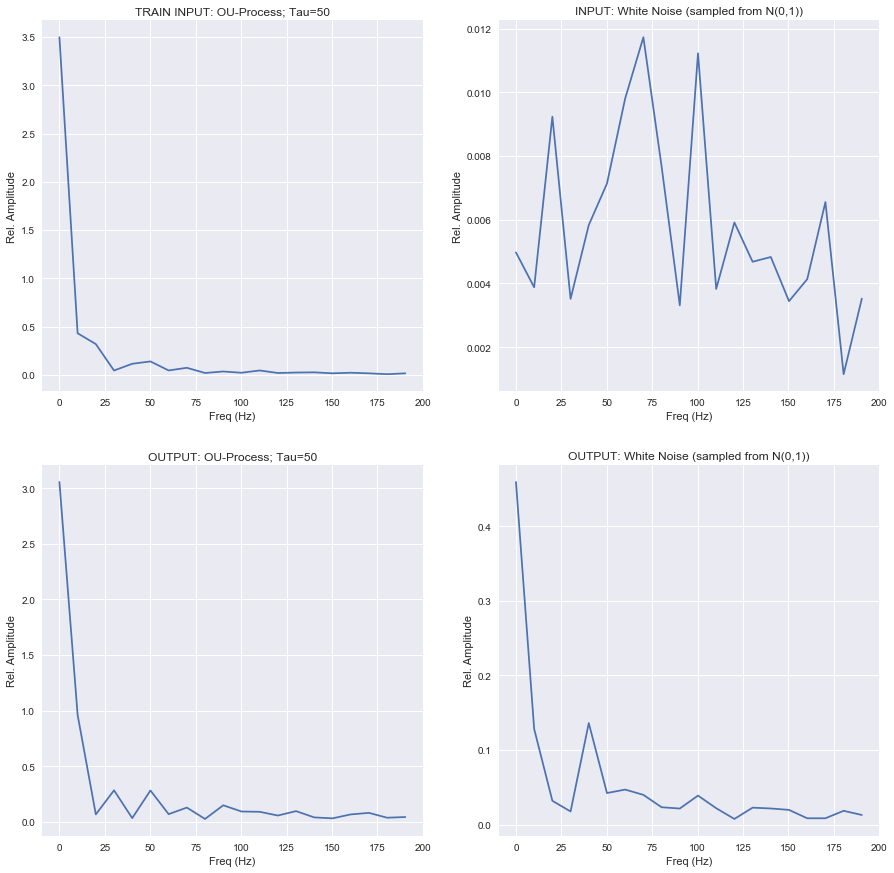

In [123]:
SAMPLE_LEN = 1000
dt_secs = dt / 1000.0
# fft_N = np.arange(0.0, SAMPLE_LEN, dt).shape[0]

i_inj_fft = scipy.fftpack.fft(i_inj[:SAMPLE_LEN, 0])
i_white_fft = scipy.fftpack.fft(i_white[:SAMPLE_LEN, 0])

ou_output_fft = scipy.fftpack.fft(out[:SAMPLE_LEN, 0])
white_output_fft = scipy.fftpack.fft(out_white[:SAMPLE_LEN, 0])

xf = np.linspace(0.0, 1.0/(2.0*dt_secs), SAMPLE_LEN/2)

_, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,15))

FREQ_START = 0
FREQ_END = 20 # SAMPLE_LEN//2

axs[0, 0].plot(xf[FREQ_START:FREQ_END], 2.0/fft_N * np.abs(i_inj_fft[FREQ_START:FREQ_END]))
axs[0, 0].set_title('TRAIN INPUT: OU-Process; Tau=50')
axs[0, 0].set_xlabel('Freq (Hz)')
axs[0, 0].set_ylabel('Rel. Amplitude')
axs[1, 0].plot(xf[FREQ_START:FREQ_END], 2.0/fft_N * np.abs(ou_output_fft[FREQ_START:FREQ_END]))
axs[1, 0].title.set_text('OUTPUT: OU-Process; Tau=50')
axs[1, 0].set_xlabel('Freq (Hz)')
axs[1, 0].set_ylabel('Rel. Amplitude')

axs[0, 1].plot(xf[FREQ_START:FREQ_END], 2.0/fft_N * np.abs(i_white_fft[FREQ_START:FREQ_END]))
axs[0, 1].set_title('INPUT: White Noise (sampled from N(0,1))')
axs[0, 1].set_xlabel('Freq (Hz)')
axs[0, 1].set_ylabel('Rel. Amplitude')
axs[1, 1].plot(xf[FREQ_START:FREQ_END], 2.0/fft_N * np.abs(white_output_fft[FREQ_START:FREQ_END]))
axs[1, 1].set_title('OUTPUT: White Noise (sampled from N(0,1))')
axs[1, 1].set_xlabel('Freq (Hz)')
axs[1, 1].set_ylabel('Rel. Amplitude')

plt.show()
# plt.savefig('fft_ou_vs_white_full.png')

In [111]:
white_layer = Layer(NUM_NEURONS)
white_layer.train(i_inj=i_white, exp_output=i_white, dt=dt, t_stop=t_stop)
white_out, white_V, white_F_binary, white_F_synaptic = white_layer.output(i_inj, dt, t_stop)

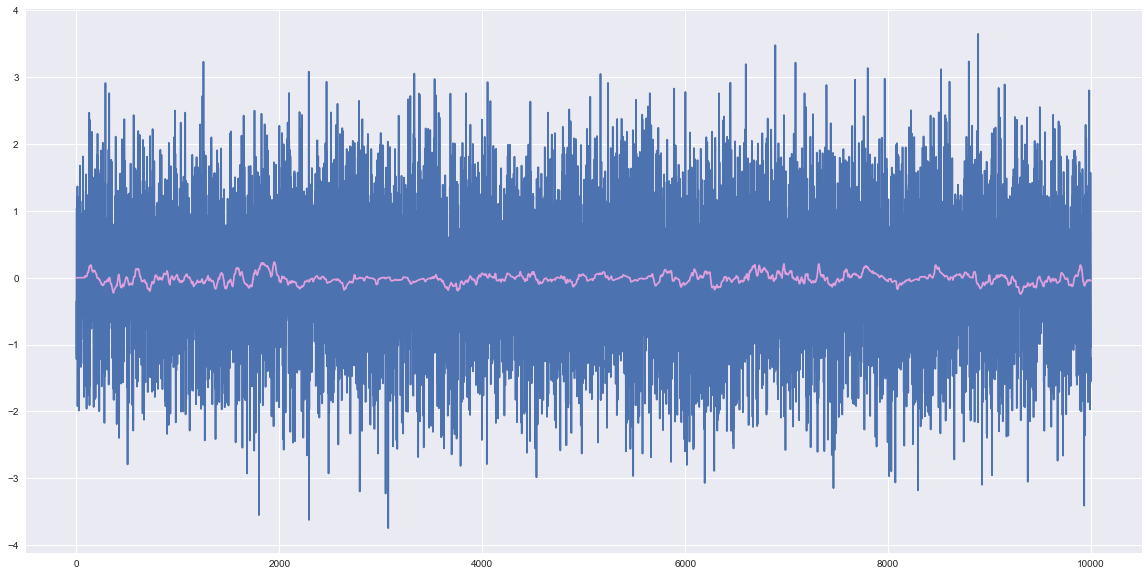

In [120]:
plt.figure(figsize=(20,10))
plt.plot(i_white[:10000])
plt.plot(white_out[:10000], 'plum')
plt.show()

In [116]:
ou_through_white, _, _, _ = white_layer.output(i_inj, dt, t_stop)

c:\program files\python35\lib\site-packages\ipykernel\__main__.py:11: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


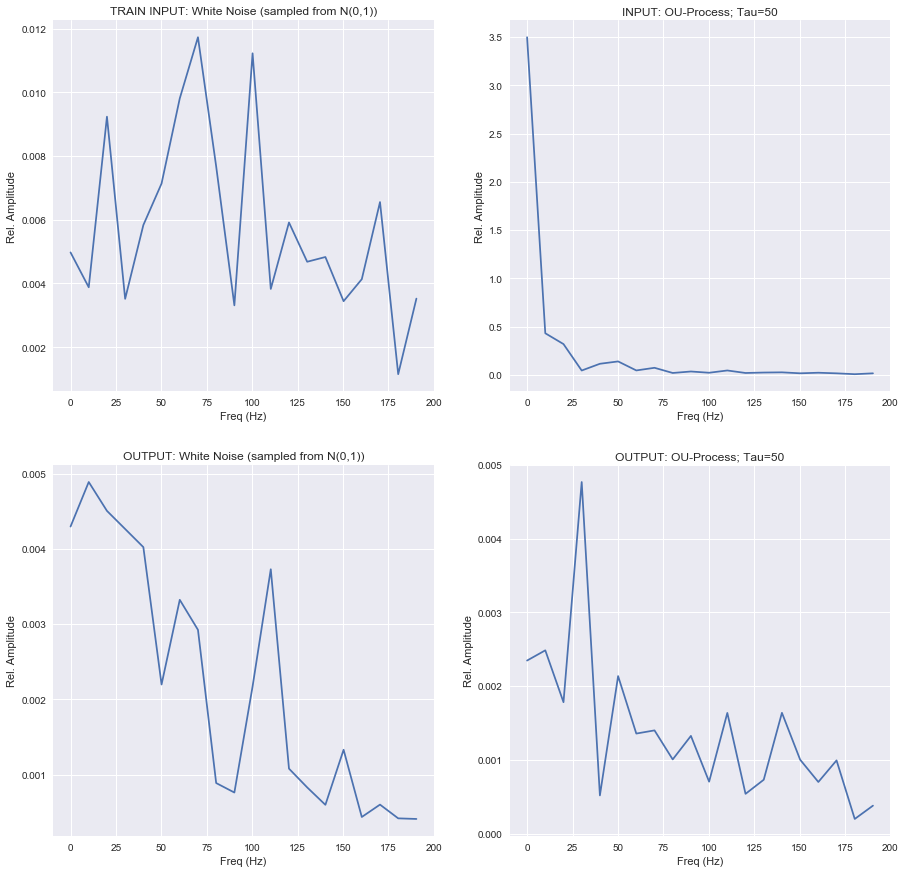

In [124]:
SAMPLE_LEN = 1000
dt_secs = dt / 1000.0
# fft_N = np.arange(0.0, SAMPLE_LEN, dt).shape[0]

i_inj_fft = scipy.fftpack.fft(i_inj[:SAMPLE_LEN, 0])
i_white_fft = scipy.fftpack.fft(i_white[:SAMPLE_LEN, 0])

ou_output_fft = scipy.fftpack.fft(ou_through_white[:SAMPLE_LEN, 0])
white_output_fft = scipy.fftpack.fft(white_out[:SAMPLE_LEN, 0])

xf = np.linspace(0.0, 1.0/(2.0*dt_secs), SAMPLE_LEN/2)

_, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,15))

FREQ_START = 0
FREQ_END = 20 # SAMPLE_LEN//2

axs[0, 0].plot(xf[FREQ_START:FREQ_END], 2.0/fft_N * np.abs(i_white_fft[FREQ_START:FREQ_END]))
axs[0, 0].set_title('TRAIN INPUT: White Noise (sampled from N(0,1))')
axs[0, 0].set_xlabel('Freq (Hz)')
axs[0, 0].set_ylabel('Rel. Amplitude')
axs[1, 0].plot(xf[FREQ_START:FREQ_END], 2.0/fft_N * np.abs(white_output_fft[FREQ_START:FREQ_END]))
axs[1, 0].set_title('OUTPUT: White Noise (sampled from N(0,1))')
axs[1, 0].set_xlabel('Freq (Hz)')
axs[1, 0].set_ylabel('Rel. Amplitude')

axs[0, 1].plot(xf[FREQ_START:FREQ_END], 2.0/fft_N * np.abs(i_inj_fft[FREQ_START:FREQ_END]))
axs[0, 1].set_title('INPUT: OU-Process; Tau=50')
axs[0, 1].set_xlabel('Freq (Hz)')
axs[0, 1].set_ylabel('Rel. Amplitude')
axs[1, 1].plot(xf[FREQ_START:FREQ_END], 2.0/fft_N * np.abs(ou_output_fft[FREQ_START:FREQ_END]))
axs[1, 1].title.set_text('OUTPUT: OU-Process; Tau=50')
axs[1, 1].set_xlabel('Freq (Hz)')
axs[1, 1].set_ylabel('Rel. Amplitude')

plt.show()
# plt.savefig('fft_ou_vs_white_full.png')